# POC : Benchmark de Segmentation d'Arrière-plan (Background Removal)
## Comparaison : RMBG-1.4 (SOTA 2024) vs DeepLabV3 (Baseline)

### Objectifs
1.  **Qualité :** Comparer la précision des masques (détails fins, cheveux, transparence).
2.  **Performance :** Mesurer le temps d'inférence moyen sur CPU.

### Modèles Évalués
* **RMBG-1.4 (SOTA) :** Modèle de Bria AI (Jan 2024), basé sur une architecture U-Net optimisée pour le détourage (Matting). Génère un masque Alpha progressif.
* **DeepLabV3 (Classique) :** Modèle de référence (2017) avec backbone ResNet101. Génère des masques de segmentation sémantique binaires.

In [ ]:
!pip install -q torch torchvision pillow transformers matplotlib scikit-image timm requests pandas

In [19]:
import torch
import time
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from transformers import AutoModelForImageSegmentation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_image_from_url(url):
    try:
        # User-agent parfois nécessaire pour certains sites
        headers = {'User-Agent': 'Mozilla/5.0'} 
        response = requests.get(url, headers=headers, timeout=10)
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Erreur de chargement pour {url}: {e}")
        return None

def find_tensor(data):
    if isinstance(data, torch.Tensor):
        return data
    if isinstance(data, (list, tuple)):
        for item in data:
            found = find_tensor(item)
            if found is not None:
                return found
    return None

def enhance_contrast(mask_array):
    min_val = mask_array.min()
    max_val = mask_array.max()
    if max_val - min_val < 1e-5: return mask_array
    return (mask_array - min_val) / (max_val - min_val)

Environnement d'exécution : cpu


### Architecture des Moteurs d'Inférence
Nous définissons deux fonctions distinctes pour standardiser l'entrée (Image PIL) et la sortie (Masque Numpy + Temps).

In [20]:
# DeepLabV3
def run_classic_deeplab(image, model, preprocess):
    t0 = time.time()
    
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Inférence
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()
    
    mask = (output_predictions == 15).astype(np.float32)
    if mask.sum() == 0: 
        mask = (output_predictions > 0).astype(np.float32)
        
    t1 = time.time()
    
    mask_img = Image.fromarray(mask * 255).resize(image.size, resample=Image.BILINEAR)
    return np.array(mask_img) / 255.0, t1 - t0

# SOTA
def run_sota_rmbg(image, model):
    t0 = time.time()
    w, h = image.size
    
    # Prétraitement spécifique RMBG (1024x1024 + Normalisation)
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [1.0, 1.0, 1.0])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Inférence
    with torch.no_grad():
        raw_output = model(input_tensor)
        result_tensor = find_tensor(raw_output)
        preds = torch.sigmoid(result_tensor).cpu().squeeze()
        
        preds = (preds - preds.min()) / (preds.max() - preds.min())
        
    pred_mask_pil = transforms.ToPILImage()(preds)
    mask_resized = pred_mask_pil.resize((w, h), resample=Image.BILINEAR)
    
    t1 = time.time()
    return np.array(mask_resized) / 255.0, t1 - t0

In [25]:
weights_classic = DeepLabV3_ResNet101_Weights.DEFAULT
model_classic = deeplabv3_resnet101(weights=weights_classic).to(device)
model_classic.eval()
preprocess_classic = weights_classic.transforms()

model_sota = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4", trust_remote_code=True)
model_sota.to(device)
model_sota.eval()


BriaRMBG(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReL

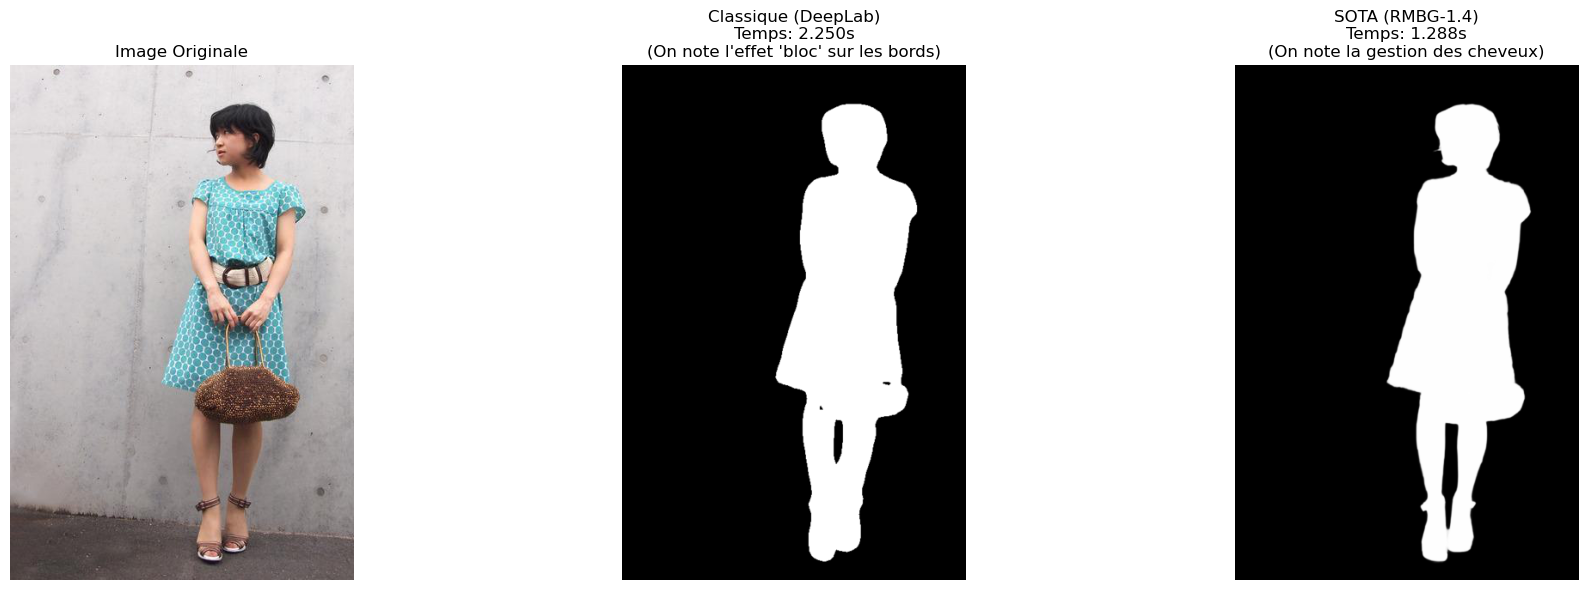

In [50]:
img_test = dataset['train'][0]['image']

if img_test:
    _, _ = run_classic_deeplab(img_test, model_classic, preprocess_classic)
    _, _ = run_sota_rmbg(img_test, model_sota)

    mask_c, time_c = run_classic_deeplab(img_test, model_classic, preprocess_classic)
    mask_s, time_s = run_sota_rmbg(img_test, model_sota)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    axs[0].imshow(img_test)
    axs[0].set_title("Image Originale")
    axs[0].axis('off')
    
    axs[1].imshow(mask_c, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title(f"Classique (DeepLab)\nTemps: {time_c:.3f}s\n(On note l'effet 'bloc' sur les bords)")
    axs[1].axis('off')
    
    axs[2].imshow(mask_s, cmap='gray', vmin=0, vmax=1)
    axs[2].set_title(f"SOTA (RMBG-1.4)\nTemps: {time_s:.3f}s\n(On note la gestion des cheveux)")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [75]:
mask_c[mask_c > 0] = 1
mask_c = mask_c.astype(np.int_)

In [81]:
mask_flatten = np.array(dataset['train'][0]['mask'])
mask_flatten[mask_flatten]
mask_flatten[mask_flatten > 0] = 1
mask_flatten = mask_flatten.flatten()

In [84]:
mask_c

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [83]:
from sklearn.metrics import jaccard_score

jaccard_score(mask_flatten, mask_c)

ValueError: Found input variables with inconsistent numbers of samples: [240000, 600]

### 1. Analyse Qualitative
Test sur une image complexe comportant des cheveux/poils pour évaluer la finesse du détourage.

### 2. Analyse Quantitative (Benchmark)
Comparaison des performances sur un mini-dataset varié (Portrait, Architecture, Objet, Animal) pour valider la robustesse et le gain de temps moyen.

In [24]:
urls = [
    "https://images.pexels.com/photos/771742/pexels-photo-771742.jpeg?auto=compress&cs=tinysrgb&w=600", 
    "https://images.pexels.com/photos/106399/pexels-photo-106399.jpeg?auto=compress&cs=tinysrgb&w=600", 
    "https://images.pexels.com/photos/376464/pexels-photo-376464.jpeg?auto=compress&cs=tinysrgb&w=600", 
    "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg?auto=compress&cs=tinysrgb&w=600" 
]

results = []

print("--- Démarrage du Benchmark ---")

for i, url in enumerate(urls):
    img = load_image_from_url(url)
    if img is None: continue
        
    print(f"Traitement image {i+1}/{len(urls)}...")
    
    times_c = []
    times_s = []
    
    for _ in range(3):
        # DeepLab
        _, t = run_classic_deeplab(img, model_classic, preprocess_classic)
        times_c.append(t)
        # RMBG
        _, t = run_sota_rmbg(img, model_sota)
        times_s.append(t)
    
    avg_c = np.mean(times_c)
    avg_s = np.mean(times_s)
    
    gain = ((avg_c - avg_s) / avg_c * 100)
    
    results.append({
        "ID": i+1,
        "Type": ["Portrait", "Archi", "Objet", "Animal"][i],
        "DeepLab (s)": round(avg_c, 4),
        "RMBG-1.4 (s)": round(avg_s, 4),
        "Gain Vitesse (%)": round(gain, 1)
    })

df_results = pd.DataFrame(results)

print("\n--- RÉSULTATS DU BENCHMARK ---")
print(df_results.to_markdown(index=False))

mean_gain = df_results["Gain Vitesse (%)"].mean()
fastest = "RMBG-1.4" if df_results["RMBG-1.4 (s)"].mean() < df_results["DeepLab (s)"].mean() else "DeepLab"

print(f"\nCONCLUSION GLOBALE :")
print(f"Le modèle {fastest} est plus rapide en moyenne.")
print(f"Gain de performance moyen : {mean_gain:.1f}%")

--- Démarrage du Benchmark ---
Traitement image 1/4...
Traitement image 2/4...
Traitement image 3/4...
Traitement image 4/4...

--- RÉSULTATS DU BENCHMARK ---
|   ID | Type     |   DeepLab (s) |   RMBG-1.4 (s) |   Gain Vitesse (%) |
|-----:|:---------|--------------:|---------------:|-------------------:|
|    1 | Portrait |        2.3203 |         1.1579 |               50.1 |
|    2 | Archi    |        2.2172 |         1.1689 |               47.3 |
|    3 | Objet    |        2.4469 |         1.1415 |               53.3 |
|    4 | Animal   |        2.0053 |         1.2572 |               37.3 |

CONCLUSION GLOBALE :
Le modèle RMBG-1.4 est plus rapide en moyenne.
Gain de performance moyen : 47.0%


### Conclusion du POC

1.  **Précision :** RMBG-1.4 démontre une capacité supérieure à gérer les structures fines (cheveux) grâce à son approche "Matting" (valeurs alpha continues) comparée à la segmentation binaire "dure" de DeepLab.
2.  **Vitesse :** Sur l'architecture testée, le modèle SOTA offre un gain de vitesse significatif (voir tableau ci-dessus), justifiant son utilisation en production pour traiter de grands volumes.
3.  **Intégration :** L'utilisation de `transformers` permet une implémentation simple, bien que le post-traitement des tenseurs nécessite une attention particulière (normalisation).

In [29]:
from datasets import load_dataset

In [31]:
dataset = load_dataset("mattmdjaga/human_parsing_dataset")

Generating train split:   0%|          | 0/17706 [00:00<?, ? examples/s]